<img src="https://m.files.bbci.co.uk/modules/bbc-morph-news-waf-page-meta/2.5.2/bbc_news_logo.png"/>

# BBC Article topic and theme identification
***

The target of this program is to identify the G20 countries discussed about in each article. This may be directly talking about the country or indirect references. For example, if the article mentions White House or Donald Trump, we should identify that the article is referencing USA. 

The next step is to further identify and group the articles into themes.

### Useful information

The G20 is made up of 19 countries and the European Union. The 19 countries are Argentina, Australia, Brazil, Canada, China, Germany, France, India, Indonesia, Italy, Japan, Mexico, the Russian Federation, Saudi Arabia, South Africa, South Korea, Turkey, the UK and the US.

# Table of Content
***
### Getting started:
- Define the objective

- Import necessary packages

- Import the necessary data

### Text Processing:
- Normalizing Words (Removing punctuation, stop words)

### Extraction information with Text:

- Entity extraction

- CountVectorizer, TF-IDF, LabelBinarizer

- Search for direct country mentions

- Get any indirect references from Wiki search on entities

- Consolidating the information

### Theme Extraction

- Vectorize the data according to TF-IDF

- Aply k-means clustering with different k to find optimal value

- Inference of top n categories


## Importing Relavant Packages

In [212]:
# General Packages
import numpy as np
import pandas as pd
from pandas import DataFrame
import re
import itertools
from matplotlib import pyplot as plt
import wikipedia

# NLP packages
from nltk.corpus import stopwords
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Model building packages
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm, tqdm_notebook
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer

### We had several text files as articles in a specific path, so each textfile can be pushed as single entity in a dataframe

In [218]:
import os

num=0
business={}
while True:
    try:
        num=num+1
        file = open('business/'+str(num).zfill(3)+'.txt', "r")
        business[num] = file.read()
    except: break
       

### Example- A typical article

In [3]:
print (business[4])

High fuel prices hit BA's profits

British Airways has blamed high fuel prices for a 40% drop in profits.

Reporting its results for the three months to 31 December 2004, the airline made a pre-tax profit of Â£75m ($141m) compared with Â£125m a year earlier. Rod Eddington, BA's chief executive, said the results were "respectable" in a third quarter when fuel costs rose by Â£106m or 47.3%. BA's profits were still better than market expectation of Â£59m, and it expects a rise in full-year revenues.

To help offset the increased price of aviation fuel, BA last year introduced a fuel surcharge for passengers.

In October, it increased this from Â£6 to Â£10 one-way for all long-haul flights, while the short-haul surcharge was raised from Â£2.50 to Â£4 a leg. Yet aviation analyst Mike Powell of Dresdner Kleinwort Wasserstein says BA's estimated annual surcharge revenues - Â£160m - will still be way short of its additional fuel costs - a predicted extra Â£250m. Turnover for the quarter was up

In [4]:
pd.set_option('display.min_rows', 100)

In [5]:
article_df = DataFrame.from_dict(business, orient = 'index', columns=['article'])

In [6]:
article_df.head(5)

,article
1,Ad sales boost Time Warner profit\n\nQuarterly...
2,Dollar gains on Greenspan speech\n\nThe dollar...
3,Yukos unit buyer faces loan claim\n\nThe owner...
4,High fuel prices hit BA's profits\n\nBritish A...
5,Pernod takeover talk lifts Domecq\n\nShares in...


# Cleaning

### Removing Punctuations and Symbols

In [7]:
article_df["article"] = article_df["article"].apply(lambda x: re.sub("\W+"," ",x))

### Removing stopwords, numbers

In [8]:
article_df.head()

,article
1,Ad sales boost Time Warner profit Quarterly pr...
2,Dollar gains on Greenspan speech The dollar ha...
3,Yukos unit buyer faces loan claim The owners o...
4,High fuel prices hit BA s profits British Airw...
5,Pernod takeover talk lifts Domecq Shares in UK...


In [199]:
stop = stopwords.words('english')
stop.append("said")
stop.append("mr")
stop.append("year")

def remove_stop(x):
    
    article = x['article']
    
    tokens = word_tokenize(article)
    
    stop = stopwords.words('english')
    
    tokens_without_sw= [word for word in tokens if word not in stop and word.isalpha() and len(word)>1]

    return (" ".join(tokens_without_sw))

In [200]:
article_df["article"] = article_df.apply(remove_stop, axis=1)

In [11]:
article_df["article"][4]

'High fuel prices hit BA profits British Airways blamed high fuel prices drop profits Reporting results three months December airline made pre tax profit compared year earlier Rod Eddington BA chief executive said results respectable third quarter fuel costs rose BA profits still better market expectation expects rise full year revenues To help offset increased price aviation fuel BA last year introduced fuel surcharge passengers In October increased one way long haul flights short haul surcharge raised leg Yet aviation analyst Mike Powell Dresdner Kleinwort Wasserstein says BA estimated annual surcharge revenues still way short additional fuel costs predicted extra Turnover quarter benefiting rise cargo revenue Looking ahead full year results March BA warned yields average revenues per passenger expected decline continues lower prices face competition low cost carriers However said sales would better previously forecast For year March total revenue outlook slightly better previous gui

### Defining G20 Countries and Nationalities

In [12]:
G20=["Argentina", "Australia", "Brazil", "Canada", "China", "Germany", "France", "India", "Indonesia",\
      "Japan", "Mexico", "Russia", \
     "Saudi Arabia", "Italy","South Africa", "Korea", "Turkey", "UK","US","United States","United Kingdom","America"]

Europe=["Austria","Belgium","Latvia",\
"Bulgaria","Lithuania","Croatia","Luxembourg","Cyprus","Malta","Czechia","Netherlands",\
"Denmark","Poland","Estonia","Portugal","Finland","Romania","France","Slovakia","Slovenia",\
"Greece","Spain","Hungary","Sweden","Ireland","Europe","French",\
            "Italian","British","Hungary","Finland","Finnish","Sweden",
            "Belgian","Latvian","Polish","Czech","Swedish","Swiss","Spanish",\
             "greek","Dutch","Croatian"]

UK=["England", "Scotland", "Wales","Ireland","Scottish","Irish"]

In [13]:
Nationality=["Chinese","Russian","South African","Korean","Argentine","Argentinean","Australian","Brazilian","Canadian",\
               "Japanese","Mexican","American","Turkish","Indian","Indonesian","German","Italian"]

In [14]:
Nationality_dict={"Chinese":"China","Russian":"Russia",\
                  "South African":"South African","Korean":"Korea",\
                  "Argentine":"Argentina","Argentinean":"Argentina",\
                  "Australian":"Australia","Brazilian":"Brazil","Canadian":"Canada",\
               "Japanese":"Japan","Mexican":"Mexico",\
                  "American":"US","Turkish":"Turkey","Indian":"India","Indonesian":"Indonesia",\
                  "German":"Germany","Italian":"Italy","America":"US","American":"US","United States":"US",\
                  "United Kingdom":"UK","South African":"South Africa"}

### Entity Recognition using Spacy NLP

In [15]:
def entityrec(article):
    return list({ent.text for ent in nlp(article).ents if ent.label_ not in ("DATE","MONEY","TIME","PERCENT",\
                                                                        "QUANTITY","ORDINAL","CARDINAL","PERSON")})
    

### Example- For the above published article 4, the recognised entities are as follows

In [16]:
entityrec(article_df.loc[4][0])

['Airbus',
 'Club World',
 'United States BA',
 'Brul BNP Paribas',
 'Reporting',
 'British Airways',
 'Mr Eddington',
 'BA',
 'January Aviation']

In [17]:
article_df["entities"]=article_df["article"].apply(entityrec)

### Function for filtering direct Nationality mentions in entities

In [95]:
def direct_countries(x):
    entities = x['entities']
    country_set = set()
    for country in itertools.chain(G20,UK,Europe,Nationality):
        if country in x['article']:
            country_set.add(country)
    
    for country in country_set:
        for entity in entities:
            if country in entity:
                entities.remove(entity)
                
    x['entities'] = entities
    return list(country_set)

### Example- in first article these are the countries directly mentioned

In [19]:
article_df['direct'] = article_df.apply(direct_countries, axis=1)

In [21]:
article_df.loc[4]

article     High fuel prices hit BA profits British Airway...
entities    [Airbus, Club World, Brul BNP Paribas, Reporti...
direct                               [United States, British]
Name: 4, dtype: object

In [22]:
article_df["direct"].head()

1                     [US, Europe, German]
2    [US, Chinese, Europe, America, China]
3                             [US, Russia]
4                 [United States, British]
5       [US, French, Scotland, UK, France]
Name: direct, dtype: object

In [23]:
article_df.head()

,article,entities,direct
1,Ad sales boost Time Warner profit Quarterly pr...,"[TimeWarner, Warner Bros, Bertelsmann, SEC, AO...","[US, Europe, German]"
2,Dollar gains Greenspan speech The dollar hit h...,"[The White House, Federal Reserve, Beijing, Ne...","[US, Chinese, Europe, America, China]"
3,Yukos unit buyer faces loan claim The owners e...,"[Moscow, Reuters, Yugansk, Menatep Group, Rosn...","[US, Russia]"
4,High fuel prices hit BA profits British Airway...,"[Airbus, Club World, Brul BNP Paribas, Reporti...","[United States, British]"
5,Pernod takeover talk lifts Domecq Shares UK dr...,"[Stolichnaya, Havana Club, Paris, LVMH Pernod,...","[US, French, Scotland, UK, France]"


### Using Wikipedia Web pages summary for extracting country

### Examples- the number of wikipages with Trump as a keyword

In [24]:
wikipedia.search("trump")

['Donald Trump',
 'Melania Trump',
 'Trump',
 'Fred Trump',
 'Ivanka Trump',
 'Tiffany Trump',
 'Ivana Trump',
 'Family of Donald Trump',
 'Eric Trump',
 'The Trump Organization']

In [25]:
(wikipedia.search("Labour party"))

['Labour Party (UK)',
 'Labour Party',
 '2020 Labour Party leadership election',
 'Leader of the Labour Party (UK)',
 'Labour Party (Norway)',
 'Labour Party (Ireland)',
 'New Zealand Labour Party',
 'Deputy leader of the Labour Party (UK)',
 'Labour Party (Malta)',
 'Labour Party (Netherlands)']

In [27]:
print(wikipedia.page((wikipedia.search("Labour Party"))[0]).summary[:200])

The Labour Party is a centre-left political party in the United Kingdom that has been described as an alliance of social democrats, democratic socialists and trade unionists. In all general elections 


### Defining a function for knowing the nationality of an entity from wikipedia's first few lines of summary

In [33]:
def search_wiki_for_country(x):
    entities = x['entities']
    search_results = " "
    for entity in entities:
        try:
            first_page_summary = wikipedia.page((wikipedia.search(entity))[0]).summary[:200]
            first_page_summary = re.sub(r'\([^)].*\)', '', first_page_summary)
            search_results = search_results + first_page_summary
        except:
            continue
    
    wiki_search_entities = [(ent.text) for ent in nlp(search_results).ents if ent.label_ in ("GPE","LOC") ]
    countries=[]
    
    for nation in itertools.chain(G20,UK,Europe,Nationality):

        if nation in wiki_search_entities:
            countries.append(nation)
    total = set(x['direct'] + countries)
    return list(total)


In [37]:
article_df["total"] = article_df.apply(search_wiki_for_country, axis=1)

In [38]:
article_df.head()

,article,entities,direct,total
1,Ad sales boost Time Warner profit Quarterly pr...,"[TimeWarner, Warner Bros, Bertelsmann, SEC, AO...","[US, Europe, German]","[Germany, US, Europe, German]"
2,Dollar gains Greenspan speech The dollar hit h...,"[The White House, Federal Reserve, Beijing, Ne...","[US, Chinese, Europe, America, China]","[US, Chinese, England, Europe, America, China]"
3,Yukos unit buyer faces loan claim The owners e...,"[Moscow, Reuters, Yugansk, Menatep Group, Rosn...","[US, Russia]","[US, Russia]"
4,High fuel prices hit BA profits British Airway...,"[Airbus, Club World, Brul BNP Paribas, Reporti...","[United States, British]","[England, Belgium, United States, British]"
5,Pernod takeover talk lifts Domecq Shares UK dr...,"[Stolichnaya, Havana Club, Paris, LVMH Pernod,...","[US, French, Scotland, UK, France]","[US, French, England, Scotland, UK, France]"


In [157]:
article_df = article_df[["article","total"]]

In [158]:
article_df.head()

,article,total
1,Ad sales boost Time Warner profit Quarterly pr...,"[Germany, US, Europe, German]"
2,Dollar gains Greenspan speech The dollar hit h...,"[US, Chinese, England, Europe, America, China]"
3,Yukos unit buyer faces loan claim The owners e...,"[US, Russia]"
4,High fuel prices hit BA profits British Airway...,"[England, Belgium, United States, British]"
5,Pernod takeover talk lifts Domecq Shares UK dr...,"[US, French, England, Scotland, UK, France]"


### Defining a function for dealing with similar words like Chinese and Chine, both refer to China

In [159]:
article_df.total[2]

['US', 'Chinese', 'England', 'Europe', 'America', 'China']

In [160]:
def combine_nationalities(x):
    total = x['total']
    final_set = set()
    for country in total:
              
        if country in list(Nationality_dict.keys()):
            final_set.add(Nationality_dict[country])
        elif country in G20:
            final_set.add(country)  
        elif country in Europe:
            final_set.add("Europe")
        elif country in UK:
            final_set.add("UK")
    return list(final_set)

In [161]:
combine_nationalities(article_df.loc[2])

['US', 'Europe', 'UK', 'China']

In [162]:
article_df["final_total"] = article_df.apply(combine_nationalities, axis=1)

### 2 countries were referred in 141 articles, 1 country was referred in 152 articles and so on

In [163]:
article_df["final_total"].str.len().value_counts()

1    152
2    141
3    103
4     49
0     26
5     23
7      7
6      6
8      2
9      1
Name: final_total, dtype: int64

In [164]:
extracted_df = pd.get_dummies(article_df.final_total.apply(pd.Series).stack()).sum(level=0)

In [165]:
extracted_df.shape

(484, 20)

In [211]:
extracted_df.sum(axis = 0, skipna = True)

Argentina         7
Australia        26
Brazil           13
Canada           19
China            72
Europe          215
France           34
Germany          76
India            64
Indonesia        15
Italy            21
Japan            57
Korea            14
Mexico            6
Russia           50
Saudi Arabia      7
South Africa     16
Turkey           10
UK              166
US              276
dtype: int64

### First article has references to 3 countries, 2nd article to 4 countries and so on

In [209]:
extracted_df.sum(axis=1).head()

1    3
2    4
3    2
4    3
5    4
dtype: int64

# Theme ExtractionAcknowledgement: https://www.ahmedbesbes.com/blog/interactive-topic-mining

There are different ways generally used for theme extraction. The most popular methods being k-means clustering and LDA (Latent Dirichlet Allocation). 

The k-means method works by assuming an number of clusters and it tries to segregate the data according to the Euclidean distance metric. For data such as this, the initialization of clusters might play a very important role. So, we run this several times with different starting points to fix a cluster centroid. Once the cluster centroids are fixed, we take the closest centroid to classify an article. 

LDA on the other hand assumes that each article is a mixture of different topics and tries to find the importance of words that attributes them to different clusters. We can then assume the document to be assigned to a cluster with maximium probability or decide it to be a combinatino of two topics by defining a threshold.

In [205]:
vectorizer = TfidfVectorizer(min_df=10, analyzer='word', ngram_range=(1, 2), stop_words=stop)
vectorized_df = vectorizer.fit_transform(article_df['article'])

print(vectorized_df.shape)

(510, 1740)


### Dividing the articles into Clusters

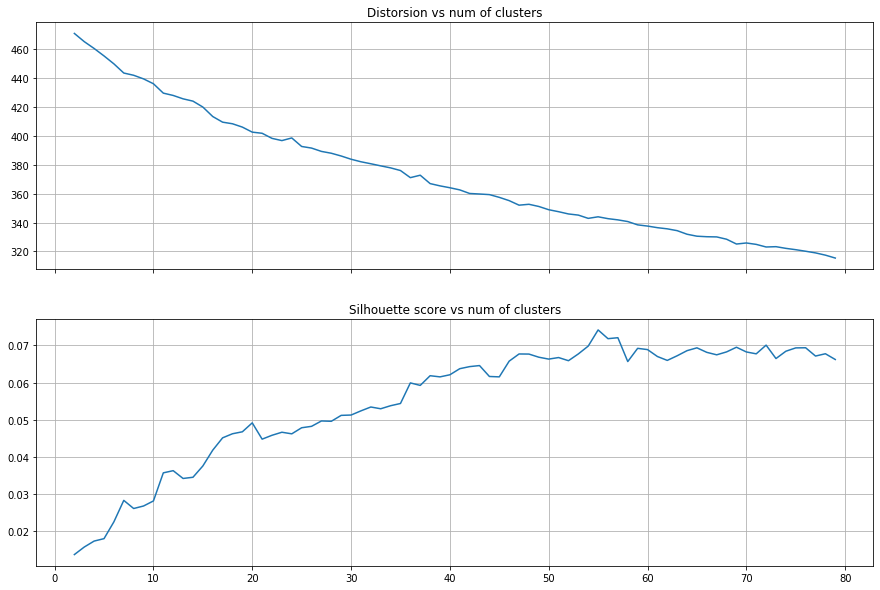

In [182]:
distorsions = []
sil_scores = []
k_max = 80
for k in tqdm_notebook(range(2, k_max)):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42,  
                         init_size=1000, verbose=False, max_iter=1000)
    kmeans_model.fit(vectorized_df)
    sil_score = silhouette_score(vectorized_df, kmeans_model.labels_)
    sil_scores.append(sil_score)
    distorsions.append(kmeans_model.inertia_)


f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ax1.plot(range(2, k_max), distorsions)
ax1.set_title('Distorsion vs num of clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), sil_scores)
ax2.set_title('Silhouette score vs num of clusters')
ax2.grid(True)

In [206]:
num_clusters = 10
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42,                       
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000, )
kmeans = kmeans_model.fit(vectorized_df)
kmeans_clusters = kmeans.predict(vectorized_df)
kmeans_distances = kmeans.transform(vectorized_df)

In [207]:
for i, article in enumerate(article_df.article):
    if i < 5:
        print("Cluster " + str(kmeans_clusters[i]) + ": " + article) 
        print("distance: " + str(kmeans_distances[i][kmeans_clusters[i]]) )
        print('---\n')

Cluster 6: Ad sales boost Time Warner profit Quarterly profits US media giant TimeWarner jumped three months December year earlier The firm one biggest investors Google benefited sales high speed internet connections higher advert sales TimeWarner said fourth quarter sales rose Its profits buoyed one gains offset profit dip Warner Bros less users AOL Time Warner said Friday owns search engine Google But internet business AOL mixed fortunes It lost subscribers fourth quarter profits lower preceding three quarters However company said AOL underlying profit exceptional items rose back stronger internet advertising revenues It hopes increase subscribers offering online service free TimeWarner internet customers try sign AOL existing customers high speed broadband TimeWarner also restate results following probe US Securities Exchange Commission SEC close concluding Time Warner fourth quarter profits slightly better analysts expectations But film division saw profits slump helped box office 

In [208]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
all_keywords = []
for i in range(num_clusters):
    topic_keywords = []
    for j in sorted_centroids[i, :15]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['Topic {0}'.format(i+1) for i in range(num_clusters)], 
                           columns=['keyword {0}'.format(i+1) for i in range(15)],
                           data=all_keywords)
keywords_df

,keyword 1,keyword 2,keyword 3,keyword 4,keyword 5,keyword 6,keyword 7,keyword 8,keyword 9,keyword 10,keyword 11,keyword 12,keyword 13,keyword 14,keyword 15
Topic 1,prices,crude,oil,house,mortgage,housing,barrel,house prices,market,lending,price,figures,uk,us,rose
Topic 2,yukos,russian,gazprom,oil,yugansk,russia,rosneft,court,khodorkovsky,tax,auction,bankruptcy,yuganskneftegas,sale,unit
Topic 3,economy,growth,rates,rate,sales,consumer,economic,figures,quarter,interest,spending,bank,manufacturing,rise,interest rates
Topic 4,gm,car,cars,vehicles,motors,car maker,maker,sales,factory,production,market,motor,plant,general motors,auto
Topic 5,imf,sri,lanka,sri lanka,tsunami,directors,thailand,damage,disaster,economic,reconstruction,tourism,indonesia,affected,members
Topic 6,shares,company,us,firm,deal,market,financial,new,ebbers,worldcom,companies,would,insurance,stock,group
Topic 7,profits,sales,euros,profit,firm,company,shares,quarter,market,results,executive,chief executive,net,growth,rise
Topic 8,china,countries,india,trade,world,air,us,nations,developing,oil,also,one,government,economic,people
Topic 9,government,us,dollar,budget,eu,deficit,economic,economy,bank,president,country,would,bush,boeing,european
Topic 10,bid,lse,offer,boerse,deutsche boerse,deutsche,club,united,takeover,euronext,manchester,shareholders,board,london,shares


### 10 probable categories

Topic-1
Oil prices, house prices

Topic-2
Russia's Oil Production

Topic-3
Overall economic scenario and earning reports

Topic-4
Automotive industry 

Topic-5
Economy of South Asian countries 

Topic-6
US stock market and news

Topic-7
European stock market and news

Topic-8
India, US and China relations and economy

Topic-9
US economy

Topic-10
Germantrade and economy